# Shooting Pattern Analysis

In this analysis, we analyze the shotchart of players. We show that there are different modes of shots, and each player's shooting style can be described as some combination of these modes.

To clean up the notebook, some functions have been moved to a local module: `helper_basketball.py`.

In [21]:
import ipywidgets as iw

menu_items = {
    'a':1,
    'b':2,
    'c':3
}

dlabel = iw.Dropdown(options=menu_items, description='label change')
dvalue = iw.Dropdown(options=menu_items, description='value change')
dboth = iw.Dropdown(options=menu_items, description='both change')

def somefunc(change):
    print(change['new'])

dlabel.observe(somefunc, names='label') # prints key when changed
dvalue.observe(somefunc, names='value') # prints value when changed
dboth.observe(somefunc, names=['label', 'value']) # prints both when changed

display(dlabel, dvalue, dboth)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [22]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import pickle

import helper_basketball as h
import imp
imp.reload(h);

In [23]:
%%bash
cat helper_basketball.py

def get_nba_data(endpoint, params, return_url=False):
    
    """Retrieves data from http://stats.nba.com
    
    For community documentation, visit 
    https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation.
    
    Args:
        endpoint: endpoint specifies data table
        params: dictionary of parameters: e.g., {'LeagueID':'00'}
        return_url: returns URL instead of downloading data then returning it
    Returns:
        out: Pandas data frame
    """
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    import subprocess as sp
    
    useragent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9"
    dataurl = "http://stats.nba.com/stats/" + endpoint + "?" + urlencode(params)
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    wgetout = sp.Popen(['wget', '-q', '-O', '-', '--user-agent='+user

## Import a python file as a module

File `helper_basketball.py` is imported as a module, and can be used like any other module. For example, you can get the docstring and function source using ? and ??, respectively.

In [24]:
## h.get_nba_data?
## h.get_nba_data??

## Get team and player data

In [27]:
## get all 2016-17 teams
params = {'LeagueID':'00','Season': '2016-17','PlayerPosition':'all'}
teams = h.get_nba_data('commonTeamYears', params).set_index('TEAM_ID')
allteams = teams.loc[teams.MAX_YEAR=='2017'].index.values

## get all 2016-17 players
params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = h.get_nba_data('commonallplayers', params).set_index('PERSON_ID')
allplyrs = players.loc[players.TEAM_ID.isin(allteams)].index.values

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

In [28]:
teams.loc[teams.MAX_YEAR=='2017'].index.values
print(teams.loc['1949'])
print(teams)

KeyError: 'the label [1949] is not in the [index]'

## Get shooting data

We follow the data collection procedure described in this paper: https://arxiv.org/abs/1401.0942.

The data consists of all shots attempted by anyone during the regular season of 2016-17. The shots are filtered in the 50' x 35' offensive court then only those who made more than 50 are included. Since the process takes a long time, I commented out the code for downloading the data, but, instead, saved the data into a pickle file.

In [33]:
# params = {'PlayerID':'201939',
#           'PlayerPosition':'all',
#           'Season':'2016-17',
#           'ContextMeasure':'FGA',
#           'DateFrom':'',
#           'DateTo':'',
#           'GameID':'',
#           'GameSegment':'',
#           'LastNGames':'0',
#           'LeagueID':'00',
#           'Location':'',
#           'Month':'0',
#           'OpponentTeamID':'0',
#           'Outcome':'',
#           'Period':'0',
#           'Position':'',
#           'RookieYear':'',
#           'SeasonSegment':'',
#           'SeasonType':'Regular Season',
#           'TeamID':'0',
#           'VsConference':'',
#           'VsDivision':''}

# shotdf = []
# for p in allplyrs:
    
#     ## get player p's data
#     params['PlayerID'] = p
#     shotdata = h.get_nba_data('shotchartdetail', params)
    
#     ## subset columns
#     sc = shotdata.loc[:,'SHOT_DISTANCE':'SHOT_MADE_FLAG']
#     sc.drop('SHOT_ATTEMPTED_FLAG', axis=1)
    
#     ## filter shots to 31 feet from end zone
#     sc = sc.loc[sc.LOC_Y < (31*12)]
    
#     ## keep data with more than 50 shots
    
#     if sc.SHOT_MADE_FLAG.sum() > 50:
        
#         sc['PlayerID'] = p
#         shotdf += [sc]

# allshots = pd.concat(shotdf)

# pickle.dump(allshots, open('allshots2016-17.pkl', 'wb'))

## Pickle module

A `pickle` file is a python module for saving data objects into a file.

In [9]:
allshots = pd.read_pickle(open('allshots2016-17.pkl', 'rb'))

# allmade = allshots.loc[allshots.SHOT_MADE_FLAG==1]
allmade = allshots
allmade.head()

,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,PlayerID
0,21,94,188,1,0,203518
1,26,-160,205,1,1,203518
2,2,20,3,1,1,203518
3,26,-150,219,1,1,203518
4,26,-52,257,1,0,203518


## Data preprocessing

We want to limit X and Y locations to 35 feet (length-wise) by 50 feet (width-wise). Data contains more of the court:

In [10]:
pd.DataFrame([allmade.LOC_X.describe(), 
              allmade.LOC_Y.describe()])

,count,mean,std,min,25%,50%,75%,max
LOC_X,202153.0,-0.245285,110.854723,-250.0,-53.0,0.0,52.0,250.0
LOC_Y,202153.0,85.151954,88.685467,-51.0,7.0,46.0,164.0,370.0


## Binned shot counts

We divide the court up into bins, and, for each player, count number of shots that fall into each bin. Then, we vectorize the bins into a row vector.

In [11]:
## players info
player_ids = allmade.PlayerID.unique()
num_players = player_ids.size

## bin edge definitions in inches
xedges = (np.linspace(start=-25, stop=25, num=151, dtype=np.float)) * 12
yedges = (np.linspace(start= -4, stop=31, num=106, dtype=np.float)) * 12

## number of bins is one less than number of edges
nx = xedges.size - 1
ny = yedges.size - 1

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = {}
all_smooth = {}

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allmade.groupby('PlayerID')):
    
    ## what does this line do?
    pid, pdf = one
    
    ## h.bin_shots: what is this function doing?
    tmp1, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
    tmp2, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
    ## vectorize and store into dictionary
    all_smooth[pid] = tmp1.reshape(-1)
    all_counts[pid] = tmp2.reshape(-1)

## Kernel smoothing (filtering)

Kernel smoothing is a frequently used function in image processing. It can also be used to smooth-out the histogram. Then, the smoothed histogram is normalized to sum to 1 to create an empirical distribution function. It is important we do this since each player has attempted different number of shots, and this procedure normalizes everyone's shooting pattern.

What is the name of the kernel smoothing function?

In [12]:
h.bin_shots??

## Visualizing star players

We will visualize the shot chart counts and smoothed fields for some players. Recall the player data structure.

In [13]:
players.head()

NameError: name 'players' is not defined

In [ ]:
## select players from paper
stars = 'LeBron James|Brook Lopez|Tyson Chandler|Marc Gasol|Tony Parker|Kyrie Irving|Stephen Curry|James Harden|Steve Novak'
players[players.DISPLAY_FIRST_LAST.str.contains(stars)].loc[player_ids].dropna() 

In [ ]:
## create figure and axes
fig, ax = plt.subplots(starids.shape[0], 2, figsize=(20,60))

for axi, plyri in enumerate(starids.index.values):
    
    h.plot_shotchart(all_counts[plyri], xedges, yedges, ax=ax[axi,0])
    h.plot_shotchart(all_smooth[plyri], xedges, yedges, ax=ax[axi,1])
    
    ax[axi,0].set_title(players.DISPLAY_FIRST_LAST[plyri]+', '+str(all_counts[plyri].sum().astype('int')))
    ax[axi,1].set_title(players.DISPLAY_FIRST_LAST[plyri]+', '+str(all_counts[plyri].sum().astype('int')))

## Non-negative matrix factorization (NMF)

Given some matrix $X$ is $p\times n$ matrix, NMF computes the following factorization:
$$ \min_{W,H} \| X - WH \|_F\\
\text{ subject to } W\geq 0,\ H\geq 0, $$
where $W$ is ${p\times r}$ matrix and $H$ is ${r\times n}$ matrix.

NMF is a unique factorization in that all values are non-negative; hence, it is used for factorization of $X$ into bases consist of non-negative values. In many practical settings such assumptions enable some realistic interpretation.

Some common applications include:
- Image processing: pixel intensities are non-negative
- Bioinformatics: gene expressions are non-negative
- Text mining: document term matrix

[This paper](https://arxiv.org/abs/1401.5226) discusses some of these in more detail.

In our case, columns of matrix $X$ represent vectorized smoothed density of one player, and we compute the non-negative $r$-bases vectors in matrix $W$. Columns in matrix $H$ are the vector of coefficients. Each coefficient in a column says how important each of the bases (columns of $W$) are.

In [14]:
## Non-negative Matrix Factorization

import sklearn.decomposition as skld

X = np.stack(all_smooth.values()).T

## what are the different options mean for NMF()?
model = skld.NMF(n_components=10, init='nndsvda', max_iter=500, random_state=0)
W = model.fit_transform(X)
H = model.components_

### Data matrix: $X$

Data matrix $X^T$ has dimensions of (number of players)-by-(number of bins), so $X$ is of dimension $n=\text{\{number of players\}}$ and $p=\text{\{number of bins\}}$.

In [15]:
p, n = X.shape

print('Number of bins (p)   :', p)
print('Number of players (n):', n)

Number of bins (p)   : 15750
Number of players (n): 362


### Bases matrix: $W$

Columns $W_i$ contain the bases. Since the function call asks for $r=10$ as number of bases, we get:

In [16]:
p_w, r = W.shape

print('Number of bins (p) :', p_w)
print('Number of bases (r):', r)

Number of bins (p) : 15750
Number of bases (r): 10


It has the shape of (number of bins)-by-(10 components).

### Coefficient matrix: H

Each column of $H$ gives a coefficient for each of the bases vectors in $W$, and there are $n$ columns for each player.

In [17]:
r_h, n_h = H.shape

print('Number of bases (r)  :', r_h)
print('Number of players (n):', n_h)

Number of bases (r)  : 10
Number of players (n): 362


### Visualizing the Bases $W$

Each column vector of $W$ gives a spatial basis. Below we plot the bases in 2-d space.

In [18]:
## h.plot_shotchart??

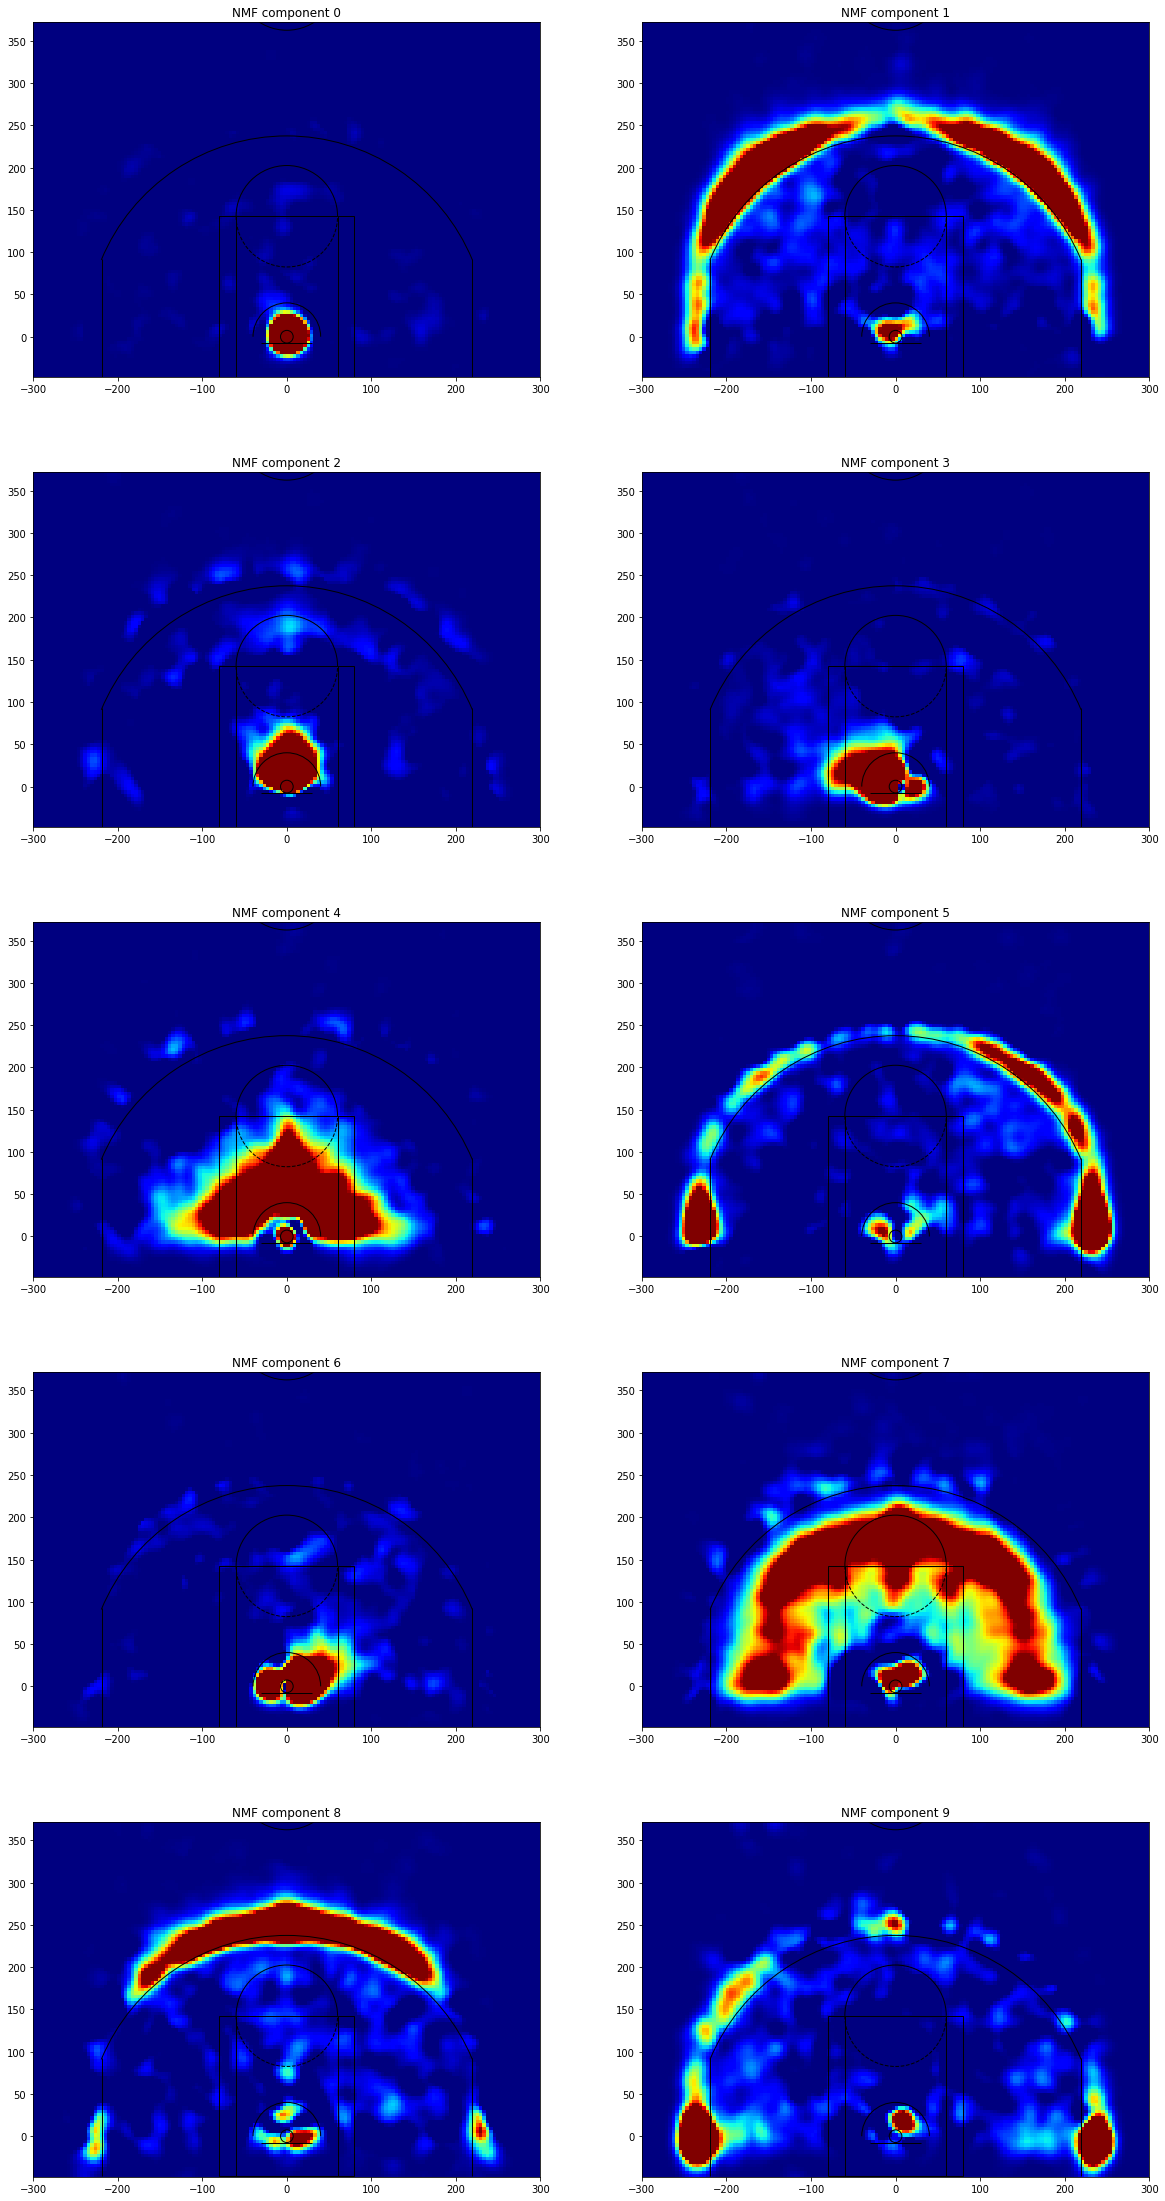

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(20,40))

for i, axi in enumerate(ax.flatten()):
    h.plot_shotchart(W[:,i], xedges, yedges, ax=axi)
    axi.set_title('NMF component ' + str(i))

## Interpreting the players shooting styles

Let's inspect the players shooting styles by looking at the coefficients.

In [20]:
## Hd holds coefficients
Hd = pd.DataFrame(H, columns=all_smooth.keys())
star_coeff = Hd.loc[:,starids.index.values]
star_coeff.columns = starids.DISPLAY_FIRST_LAST
star_coeff.T

NameError: name 'starids' is not defined

Note that these players coefficients are not scaled to sum to 1.

In [ ]:
star_coeff.T.sum(1)

So we scale each player to sum to 1.

In [ ]:
star_coeff /= star_coeff.sum(0)
star_coeff.T

In [ ]:
star_coeff.T.sum(1)